In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from scipy import stats
from astropy.modeling.fitting import LevMarLSQFitter
import astropy.units as u
from sbpy.photometry import HG, HG1G2, HG12, HG12_Pen16
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

In [4]:
sys.path.append("/Users/jrobinson/atlas-phase-curves/atlas-phase-curves")
from calculate_phase import atlas_SQL_query_df
from calculate_phase import atlas_database_connection
from calculate_phase import solar_apparitions as sa

In [5]:
# sys.path.append("/home/astro/atlas-phase-curves/atlas-phase-curves/tools")
sys.path.append("/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/tools")
import database_tools as dbt
import importlib

In [6]:
importlib.reload(dbt)
importlib.reload(atlas_SQL_query_df)

<module 'calculate_phase.atlas_SQL_query_df' from '/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/calculate_phase/atlas_SQL_query_df.py'>

In [7]:
# name = "Osipovia"
# mpc_number = 4986

# name = "Fitzsimmons"
# name = "Moguntia"
# name = "1997 YU10" # need a minimum number of data points per epoch
# name = "Aidamina" # need a minimum phase angle requirement
# name = "Cerberus" # large rotational variation
# name = "Patroclus"
name = "Fanatica"
# name = "Phereclos" 
mpc_number = False

In [8]:
# # data_file = "/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/results_analysis/obs/df_data_{}.csv".format(mpc_number)
# data_file = "/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/results_analysis/obs/df_data_{}.csv".format(name)
# df_data_filt = pd.read_csv(data_file,index_col = 0)
# df_data_filt

In [9]:
# connect to database
cnx=atlas_database_connection.database_connection().connect()

In [10]:
orbid=atlas_SQL_query_df.get_orb_elements_id(cnx,mpc_number,name)
df_data_filt=atlas_SQL_query_df.atlas_SQL_query_orbid_expname(cnx,orbid)
df_data = df_data_filt

mpc_number=False
name=Fanatica
orbital_elements_id=1589


In [11]:
df_HG = atlas_SQL_query_df.get_astorb_HG(cnx,orbid)
df_HG

,name,mpc_number,G_slope,H_abs_mag,H_abs_mag_o,H_abs_mag_c
0,Fanatica,1589,0.15,11.97,11.638,12.024


In [12]:
df_data_filt = df_data_filt.sort_values("mjd")

In [13]:
df_data_filt

,expname,dec_deg,ra_deg,mjd,m,merr,filter,observer_distance,heliocentric_distance,phase_angle,reduced_mag,apparent_mag,galactic_latitude,sun_obs_target_angle,orbfit_separation_arcsec
1,02a57400o0549c,14.546113,160.800299,57400.560822,16.102,0.022,c,1.721480,2.518880,15.8927,12.916453,15.850,57.6304,135.4623,0.189767
0,02a57400o0555c,14.546416,160.800034,57400.564583,16.143,0.023,c,1.721448,2.518883,15.8914,12.957490,15.850,57.6303,135.4664,0.200774
4,02a57400o0608c,14.549348,160.797459,57400.601076,16.000,0.018,c,1.721142,2.518915,15.8795,12.814850,15.849,57.6295,135.5067,0.246941
2,02a57400o0616c,14.549766,160.797091,57400.606296,16.054,0.021,c,1.721098,2.518919,15.8778,12.868901,15.849,57.6293,135.5125,0.069207
3,02a57400o0618c,14.549864,160.797005,57400.607512,16.074,0.018,c,1.721088,2.518920,15.8774,12.888913,15.849,57.6293,135.5138,0.056591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,01a59551o0057o,-22.289101,309.861907,59551.216273,16.459,0.030,o,2.671314,2.265433,21.0472,12.549619,16.932,-33.1500,-55.6013,0.305153
1591,01a59563o0034o,-20.800508,315.478873,59563.194583,16.374,0.240,o,2.777575,2.255915,19.1991,12.389057,16.949,-37.6192,-48.8982,0.445967
1592,01a59563o0041o,-20.800073,315.480393,59563.197813,16.537,0.099,o,2.777603,2.255913,19.1986,12.552038,16.949,-37.6204,-48.8964,0.349471
1593,01a59563o0060o,-20.798891,315.484521,59563.206586,16.500,0.068,o,2.777678,2.255906,19.1972,12.514985,16.949,-37.6237,-48.8915,0.197524


In [14]:
np.unique(df_data_filt["filter"])

array(['c', 'g', 'i', 'o', 'r'], dtype=object)

In [15]:
# load all fits to get object metadata
fname = "atlas_phase_fits_orbs_25_4_2022.csv" # contains more data, up to mjd = 59595 (2022-01-16)
df_all_data = dbt.load_atlas_phase_fits(fname)
df_all_data["q_perihelion"] = df_all_data["a_semimajor_axis"] * (1.0 - df_all_data["e_eccentricity"])

In [16]:
df_obj = df_all_data[df_all_data["name"]==name] 

In [17]:
df_obj[["phase_curve_H_err_B89_o","phase_curve_G_err_B89_o"]]

,phase_curve_H_err_B89_o,phase_curve_G_err_B89_o
1586,0.005165,0.005921


In [18]:
# Find the solar apparitions from elongation
# USE ALL DATA IN BOTH FILTERS?
orbital_period_yrs = df_obj.iloc[0]["a_semimajor_axis"]**1.5
sol = sa.solar_apparitions(mpc_number = mpc_number, name = name, df_data = df_data_filt)
epochs = sol.solar_elongation(-1.0,period = orbital_period_yrs)
# epochs = sol.solar_elongation_JPL(JPL_step="7d")

print(epochs)
N_app = len(epochs)-1 # number of apparitions detected in both filters
print(N_app)

use passed df_data
12.605567141331615
0.022
synodic period = 497.58644436461157
[57400.560822  57826.556065  58298.6009332 58775.622836  59255.640278
 59563.218588 ]
[57400.560822  57826.556065  58298.6009332 58775.622836  59255.640278
 59563.218588 ]
5


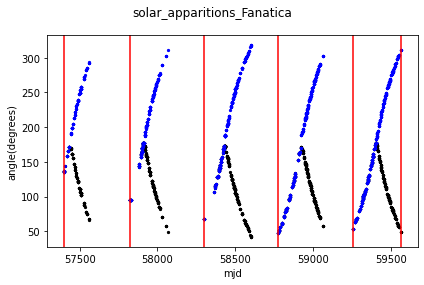

In [19]:
sol.plot_solar_elongation(epochs)

In [20]:
epochs_JPL = sol.solar_elongation_JPL(JPL_step="7d")
print(epochs_JPL)
N_app_JPL = len(epochs_JPL)-1 # number of apparitions detected in both filters
print(N_app_JPL)

query Horizons
[57400.560822 57680.       58163.       58688.       59164.
 59563.218588]
5


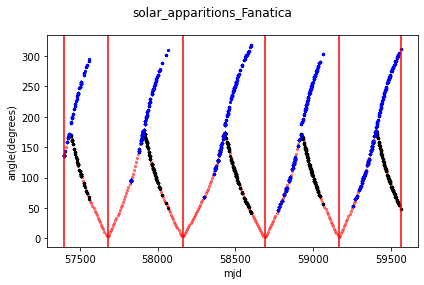

In [21]:
sol.plot_solar_elongation(epochs_JPL)

Text(0.5, 1.0, 'Fanatica')

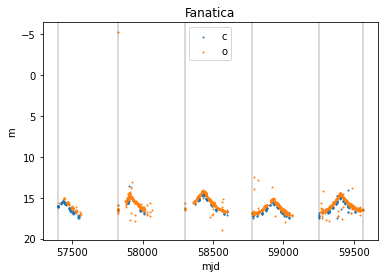

In [22]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot1 = df_data_filt[df_data_filt["filter"]=="c"]
df_plot2 = df_data_filt[df_data_filt["filter"]=="o"]

ax1.scatter(df_plot1["mjd"],df_plot1["m"],s=1, label = "c")
ax1.scatter(df_plot2["mjd"],df_plot2["m"],s=1, label = "o")

for x in epochs:
    ax1.axvline(x,c="k",alpha = 0.2)
    
# for x in epochs_JPL:
#     ax1.axvline(x,c="r")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("mjd")
ax1.set_ylabel("m")
ax1.set_title(name)

Text(0.5, 1.0, 'Fanatica')

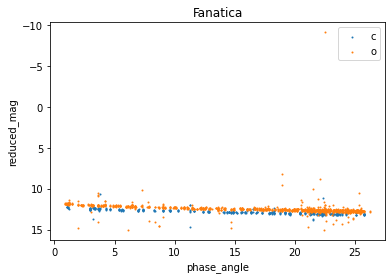

In [23]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot1 = df_data_filt[df_data_filt["filter"]=="c"]
df_plot2 = df_data_filt[df_data_filt["filter"]=="o"]

ax1.scatter(df_plot1["phase_angle"],df_plot1["reduced_mag"],s=1, label = "c")
ax1.scatter(df_plot2["phase_angle"],df_plot2["reduced_mag"],s=1, label = "o")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")
ax1.set_title(name)

# reject outlying data

In [24]:
list(df_data_filt)

['expname',
 'dec_deg',
 'ra_deg',
 'mjd',
 'm',
 'merr',
 'filter',
 'observer_distance',
 'heliocentric_distance',
 'phase_angle',
 'reduced_mag',
 'apparent_mag',
 'galactic_latitude',
 'sun_obs_target_angle',
 'orbfit_separation_arcsec']

In [25]:
orbfit_sep_cut = 1.0
mag_err_small = 0.005
gal_lat_cut = 10.0

# drop any nans
df_data = df_data_filt.dropna(subset=["mjd","reduced_mag","merr"])
print(len(df_data))
# drop large orbfit uncertainties
df_data = df_data[df_data["orbfit_separation_arcsec"]<=orbfit_sep_cut]
print(len(df_data))
# drop small (or zero) uncertainties
df_data = df_data[df_data["merr"]>=mag_err_small]
print(len(df_data))

# drop near galactic plane
df_data = df_data[np.absolute(df_data["galactic_latitude"])>=gal_lat_cut]
print(len(df_data))

# drop on mag5sig/limiting magnitude when possible


1595
1497
1489
1415


Text(0.5, 1.0, 'Fanatica')

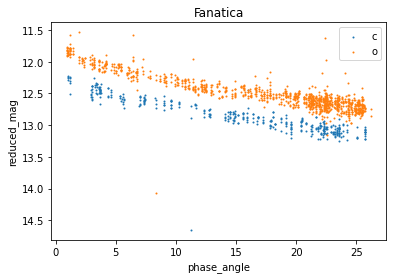

In [26]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot1 = df_data[df_data["filter"]=="c"]
df_plot2 = df_data[df_data["filter"]=="o"]

ax1.scatter(df_plot1["phase_angle"],df_plot1["reduced_mag"],s=1, label = "c")
ax1.scatter(df_plot2["phase_angle"],df_plot2["reduced_mag"],s=1, label = "o")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")
ax1.set_title(name)

Text(0.5, 1.0, 'Fanatica')

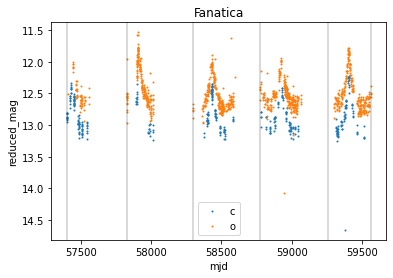

In [27]:
x_plot = "mjd"
# y_plot = "m"
y_plot = "reduced_mag"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot1 = df_data[df_data["filter"]=="c"]
df_plot2 = df_data[df_data["filter"]=="o"]

ax1.scatter(df_plot1[x_plot],df_plot1[y_plot],s=1, label = "c")
ax1.scatter(df_plot2[x_plot],df_plot2[y_plot],s=1, label = "o")

for x in epochs:
    ax1.axvline(x,c="k",alpha = 0.2)
    
# for x in epochs_JPL:
#     ax1.axvline(x,c="r")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.set_title(name)

In [28]:
# sbpy phase curve models
# model_atlas = HG(H = H_B89_o * u.mag, G = G_B89_o)

# use the astorb H and G here? Our fits might be bad for strong apparition effects!
# model_atlas = HG(H = 13.48 * u.mag, G = 0.15)
model_atlas = HG(H = df_HG.iloc[0]["H_abs_mag_o"] * u.mag, G = df_HG.iloc[0]["G_slope"])

print(model_atlas)

Model: HG
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      H     G  
     mag       
    ------ ----
    11.638 0.15


Text(0.5, 1.0, 'Fanatica')

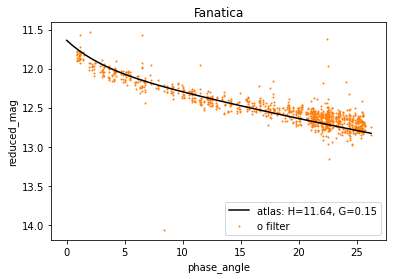

In [29]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot = df_data[df_data["filter"]=="o"]

ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1,c="C1", label = "o filter")

# evaluate the HG models
phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
reduced_mag_atlas = model_atlas(phase_angle)

ax1.plot(phase_angle,reduced_mag_atlas,c="k",
         label = "atlas: H={:.2f}, G={:.2f}".format(model_atlas.H.value,model_atlas.G.value))

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")
ax1.set_title(name)

# fit a simple HG curve to largest epoch using bootstrap

In [30]:
# HG_model = HG(H = H_B89_o * u.mag, G = 0.15) # use the astorb G if available
HG_model = HG(H = 13.48 * u.mag, G = 0.15)

# HG_model.G.fixed = True
fitter = LevMarLSQFitter()

print(HG_model)

Model: HG
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      H    G  
     mag      
    ----- ----
    13.48 0.15


In [31]:
HG_model.H.value

13.48

In [32]:
epochs

array([57400.560822 , 57826.556065 , 58298.6009332, 58775.622836 ,
       59255.640278 , 59563.218588 ])

In [33]:
df_epoch = pd.DataFrame()
df_epoch["epoch"] = np.arange(len(epochs[:-1]))
df_epoch["mjd_start"] = epochs[:-1]
df_epoch

,epoch,mjd_start
0,0,57400.560822
1,1,57826.556065
2,2,58298.600933
3,3,58775.622836
4,4,59255.640278


In [34]:
# for each epoch count the number of data points, phase angle range and number of obs at <5 degrees phase
N_data_epoch = []
phase_range = []
phase_lt_5 = []

for i,x in enumerate(epochs[1:]):
    mask = ((df_data["mjd"]>=epochs[i]) & (df_data["mjd"]<epochs[i+1])) & (df_data["filter"]=="o")
    df = df_data[mask]
    N_data_epoch.append(len(df))
    if len(df)==0:
        phase_range.append(np.nan)
        phase_lt_5.append(np.nan)
    else:
        phase_range.append(np.ptp(df["phase_angle"]))
        phase_lt_5.append(len(df[df["phase_angle"]<5.0]))
    print("N_data = {}".format(N_data_epoch[-1]))
    print("phase range = {} degrees".format(phase_range[-1]))
    print("N_data<5degrees = {}".format(phase_lt_5[-1]))
df_epoch["N_data"] = N_data_epoch
df_epoch["phase_angle_range"] = phase_range
df_epoch["phase_angle_<5"] = phase_lt_5
df_epoch

N_data = 60
phase range = 18.9548 degrees
N_data<5degrees = 7
N_data = 193
phase range = 23.4843 degrees
N_data<5degrees = 50
N_data = 255
phase range = 23.2308 degrees
N_data<5degrees = 18
N_data = 270
phase range = 19.4139 degrees
N_data<5degrees = 7
N_data = 255
phase range = 24.51 degrees
N_data<5degrees = 32


,epoch,mjd_start,N_data,phase_angle_range,phase_angle_<5
0,0,57400.560822,60,18.9548,7
1,1,57826.556065,193,23.4843,50
2,2,58298.600933,255,23.2308,18
3,3,58775.622836,270,19.4139,7
4,4,59255.640278,255,24.5100,32


In [35]:
# use a standard scaler to allow us to choose the best combination of number of data points, phase angle range and number of data points <5 deg
X = df_epoch[["N_data","phase_angle_range","phase_angle_<5"]]
X = StandardScaler().fit_transform(X)
X = np.sum(X, axis = 1)
df_epoch["scaled"] = X
X

array([-4.14451349,  2.17007955,  0.90440641, -1.24895016,  2.31897769])

In [36]:
df_epoch.sort_values("scaled", inplace = True)
df_epoch

,epoch,mjd_start,N_data,phase_angle_range,phase_angle_<5,scaled
0,0,57400.560822,60,18.9548,7,-4.144513
3,3,58775.622836,270,19.4139,7,-1.248950
2,2,58298.600933,255,23.2308,18,0.904406
1,1,57826.556065,193,23.4843,50,2.170080
4,4,59255.640278,255,24.5100,32,2.318978


In [37]:
# epoch_max = np.argmax(N_data_epoch)
epoch_max = int(df_epoch[~np.isnan(df_epoch["scaled"])].iloc[-1]["epoch"])
print(epoch_max)
print(epoch_max,epochs[epoch_max], epochs[epoch_max+1])

4
4 59255.640278 59563.218588


In [38]:
mask = ((df_data["mjd"]>=epochs[i]) & (df_data["mjd"]<epochs[i+1])) & (df_data["filter"]=="o")
df = df_data[mask]
print(len(df))

255


In [39]:
# select data at largest epoch
i = epoch_max
mask = ((df_data["mjd"]>=epochs[i]) & (df_data["mjd"]<epochs[i+1])) & (df_data["filter"]=="o")
df_max = df_data[mask]

In [40]:
len(df_max)

255

[0.00861504 0.00995976]


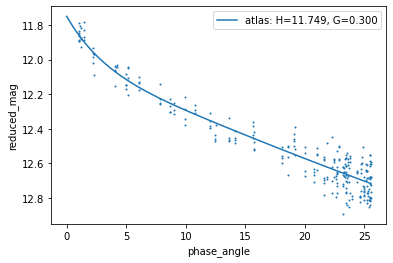

In [41]:
# do the first fit

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

alpha = np.array(df_max["phase_angle"]) * u.deg
mag = np.array(df_max["reduced_mag"]) * u.mag
mag_err = np.array(df_max["merr"]) * u.mag

model1 = fitter(HG_model, alpha, mag, weights=1.0/np.array(mag_err))
param_cov = fitter.fit_info['param_cov']
param_err_x = np.sqrt(np.diag(param_cov))
print(param_err_x)

df_plot = df_max


ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1)
phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
reduced_mag_atlas = model1(phase_angle)
ax1.plot(phase_angle,reduced_mag_atlas,
         label = "atlas: H={:.3f}, G={:.3f}".format(model1.H.value,model1.G.value))

ax1.legend()
ax1.invert_yaxis()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")

plt.show()

In [42]:
def bootstrap_fit(df, N = 100, frac = 1, plot = False):

    H_list = []
    G_list = []

    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    for i in range(N):

    #     print(i)

        # resample with replacement
        _df = df.sample(frac = frac, replace = True)  
    #     print(_df)    
        alpha = np.array(_df["phase_angle"]) * u.deg
        mag = np.array(_df["reduced_mag"]) * u.mag
        mag_err = np.array(_df["merr"]) * u.mag

        model = fitter(HG_model, alpha, mag, weights=1.0/np.array(mag_err))

        H_list.append(model.H.value)
        G_list.append(model.G.value)

        df_plot = _df

        ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1)
        phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
        reduced_mag_atlas = model(phase_angle)
        ax1.plot(phase_angle,reduced_mag_atlas,
                 label = "atlas: H={:.2f}, G={:.2f}".format(model.H.value,model.G.value))

    H_list = np.array(H_list)
    G_list = np.array(G_list)

    ax1.invert_yaxis()
    ax1.set_xlabel("phase_angle")
    ax1.set_ylabel("reduced_mag")
    
    if plot:
        plt.show()
    else:
        plt.close()
    
    return H_list, G_list

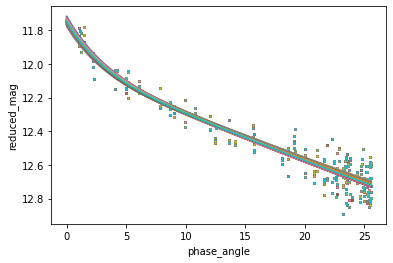

In [43]:
H_list, G_list = bootstrap_fit(df_max, plot = True)

In [44]:
def gauss_fit(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [45]:
def fit_HG_dist(data_list = [H_list,G_list], bins = "auto", plot = False):

    fig = plt.figure()
    gs = gridspec.GridSpec(1,2)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    
    coeff_list = []

    for data, ax in zip(data_list,[ax1,ax2]):

        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [1., np.median(data), np.ptp(data)/2.0]

        hist, bin_edges = np.histogram(data, density=True, bins = bins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

        coeff, var_matrix = curve_fit(gauss_fit, bin_centres, hist, p0=p0)
        coeff_list.append(coeff)

        # Get the fitted curve
        x_grid = np.linspace(np.amin(bin_centres), np.amax(bin_centres), 100)
        hist_fit = gauss_fit(x_grid, *coeff)
        ax.plot(x_grid,hist_fit, label = "mu = {:.3f}, sig = {:.3f}".format(coeff[1],coeff[2]))
        ax.axvline(coeff[1])
        ax.axvline(coeff[1]+coeff[2])
        ax.axvline(coeff[1]-coeff[2])

        ax.hist(data, bins=bins, histtype="step", density = True, color = "k")
        ax.bar(x=bin_centres, height=hist, width=np.diff(bin_edges))

        ax.legend()

    ax1.set_xlabel("H")
    ax1.set_ylabel("density")
    ax2.set_xlabel("G")
    ax2.set_ylabel("density")

    plt.tight_layout()
    
    if plot:
        plt.show()
    else:
        plt.close()
    
    return coeff_list

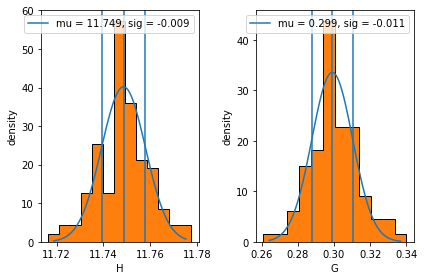

[array([ 4.02105522e+01,  1.17485693e+01, -9.39141288e-03]),
 array([ 3.35883196e+01,  2.99049672e-01, -1.12942764e-02])]

In [46]:
fit_HG_dist(data_list = [H_list,G_list], bins = "auto", plot = True)

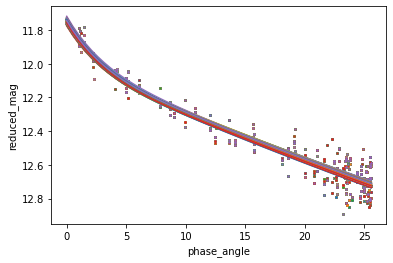

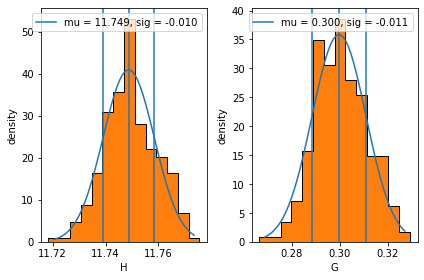

In [47]:
H_list, G_list = bootstrap_fit(df_max, N = len(df_max), plot = True)
fit_HG_dist(data_list = [H_list,G_list], bins = "auto", plot = True)

H_std = np.std(H_list)
G_std = np.std(G_list)

In [48]:
# # modify the number of bootstraps
# N_list = [10,50,100,200,400,600,800,1000]#, 1500, 2000, 3000, 4000, 5000, 7500, 10000, 20000, 30000, 50000]

# fig = plt.figure()
# gs = gridspec.GridSpec(2,2)
# ax1 = plt.subplot(gs[0,0])
# ax2 = plt.subplot(gs[0,1])
# ax3 = plt.subplot(gs[1,0])
# ax4 = plt.subplot(gs[1,1])

# for N in N_list:
#     print(N)
#     H_list, G_list = bootstrap_fit(df_max, N = N)
#     coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto")
    
#     # plot the mean H and G 
#     ax1.scatter(N,coeffs[0][1], c = "C0")
#     ax3.scatter(N,coeffs[1][1], c = "C0")
    
#     # plot the sigma H and G
#     ax2.scatter(N,np.absolute(coeffs[0][2]), c = "C1")
#     ax4.scatter(N,np.absolute(coeffs[1][2]), c = "C1")
    
# ax1.set_xlabel("N")
# ax1.set_ylabel("mean")
# ax2.set_xlabel("N")
# ax2.set_ylabel("sigma")
# ax3.set_xlabel("N")
# ax3.set_ylabel("mean")
# ax4.set_xlabel("N")
# ax4.set_ylabel("sigma")

# plt.tight_layout()
# plt.show()

In [49]:
# # modify the sample fraction
# N = 100
# frac_list = [1.0,0.9,0.8,0.6,0.5]

# fig = plt.figure()
# gs = gridspec.GridSpec(2,2)
# ax1 = plt.subplot(gs[0,0])
# ax2 = plt.subplot(gs[0,1])
# ax3 = plt.subplot(gs[1,0])
# ax4 = plt.subplot(gs[1,1])

# for f in frac_list:
#     print(N, f)
#     H_list, G_list = bootstrap_fit(df_max, N = N, frac = f)
#     coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto")
    
#     # plot the mean H and G 
#     ax1.scatter(f,coeffs[0][1], c = "C0")
#     ax3.scatter(f,coeffs[1][1], c = "C0")
    
#     # plot the sigma H and G
#     ax2.scatter(f,np.absolute(coeffs[0][2]), c = "C1")
#     ax4.scatter(f,np.absolute(coeffs[1][2]), c = "C1")
    
# ax1.set_xlabel("frac")
# ax1.set_ylabel("mean")
# ax2.set_xlabel("frac")
# ax2.set_ylabel("sigma")
# ax3.set_xlabel("v")
# ax3.set_ylabel("mean")
# ax4.set_xlabel("frac")
# ax4.set_ylabel("sigma")

# plt.tight_layout()
# plt.show()

0
100 1.0
200 1.0
300 1.0
400 1.0
500 1.0
1
100 1.0
200 1.0
300 1.0
400 1.0
500 1.0
2
100 1.0
200 1.0
300 1.0
400 1.0
500 1.0


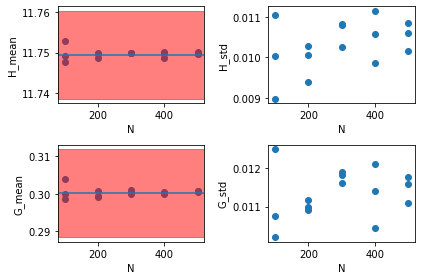

In [50]:
# modify the number of bootstraps
N_list = [100,200,300,400,500]
# frac_list = [1.0,0.9,0.8,0.7]
# N_list = [100,300,500,700,900,1000]
frac_list = [1.0]
N_repeat = 3

# N_list = [500,1000,1500,2000]
# frac_list = [1.0]
# N_repeat = 1

fig = plt.figure()
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

for j in range(N_repeat):
    print(j)
    for i,f in enumerate(frac_list):
        for N in N_list:
            print(N,f)

    #         coeffs = []
    #         while len(coeffs)==0:
    #             H_list, G_list = bootstrap_fit(df, N = N, frac = f)
    #             try:
    #                 coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto")
    #             except:
    #                 continue

            H_list, G_list = bootstrap_fit(df_max, N = N, frac = f)#, plot = True)
        
#             coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto")#, plot = True)
#             H_mu = coeffs[0][1]
#             G_mu = coeffs[1][1]
#             H_std = np.absolute(coeffs[0][2])
#             G_std = np.absolute(coeffs[1][2])
    
            H_mu = np.mean(H_list)
            G_mu = np.mean(G_list)
            H_std = np.std(H_list)
            G_std = np.std(G_list)
            
            # plot the mean H and G 
            ax1.scatter(N,H_mu, c = "C{}".format(i))
            ax3.scatter(N,G_mu, c = "C{}".format(i))

            # plot the sigma H and G
            ax2.scatter(N,H_std, c = "C{}".format(i))
            ax4.scatter(N,G_std, c = "C{}".format(i))

# plot the first fit
ax1.axhline(model1.H.value)
ax3.axhline(model1.G.value)
# indicate the std from the last bootstrap
ax1.axhspan(model1.H.value+H_std, model1.H.value-H_std, alpha=0.5, color = "r")
ax3.axhspan(model1.G.value+G_std, model1.G.value-G_std, alpha=0.5, color = "r")

ax1.set_xlabel("N")
ax1.set_ylabel("H_mean")
ax2.set_xlabel("N")
ax2.set_ylabel("H_std")
ax3.set_xlabel("N")
ax3.set_ylabel("G_mean")
ax4.set_xlabel("N")
ax4.set_ylabel("G_std")

plt.tight_layout()
plt.show()

# fit H, but not G, to every other epoch

In [51]:
# values and errors from LSQ fitter
print("H = {} +/- {}".format(model1.H.value,param_err_x[0]))
print("G = {} +/- {}".format(model1.G.value,param_err_x[1]))

H = 11.749457091324787 +/- 0.008615041697042235
G = 0.3001222804829294 +/- 0.009959763186718098


In [52]:
print(len(df_max))

255


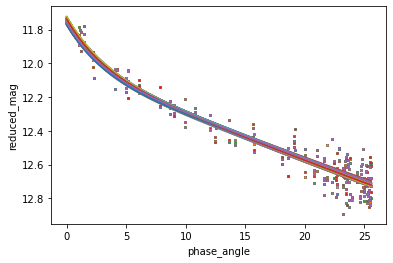

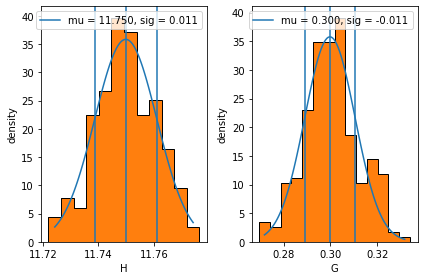

H = 11.749842688930972 +/- 0.010769312131024554
G = 0.3005838573755311 +/- 0.011750089241634695
H = 11.749830324110981 +/- 0.010769312131024554
G = 0.30059584974626924 +/- 0.011750089241634695


In [53]:
H_list, G_list = bootstrap_fit(df_max, N = len(df_max), plot = True)
coeffs = fit_HG_dist(data_list = [H_list,G_list], bins = "auto", plot = True)
# print(coeffs[0][2],coeffs[1][2])

H_mean = np.mean(H_list)
G_mean = np.mean(G_list)
H_med = np.median(H_list)
G_med = np.median(G_list)
H_std = np.std(H_list)
G_std = np.std(G_list)

# values and errors from bootstrap
print("H = {} +/- {}".format(H_mean,H_std))
print("G = {} +/- {}".format(G_mean,G_std))
print("H = {} +/- {}".format(H_med,H_std))
print("G = {} +/- {}".format(G_med,G_std))

In [54]:
# values from initial fit and errors from bootstrap
print("H = {} +/- {}".format(model1.H.value,H_std))
print("G = {} +/- {}".format(model1.G.value,G_std))

H = 11.749457091324787 +/- 0.010769312131024554
G = 0.3001222804829294 +/- 0.011750089241634695


In [55]:
HG_model_fixed = HG(H = model1.H.value * u.mag, G = model1.G.value)
HG_model_fixed.G.fixed = True
fitter = LevMarLSQFitter()

In [56]:
print(H_std/param_err_x[0])
print(G_std/param_err_x[1])

1.2500591999133255
1.1797558858933612


In [57]:
params = HG_model_fixed.param_names
params

('H', 'G')

60
193
255
270


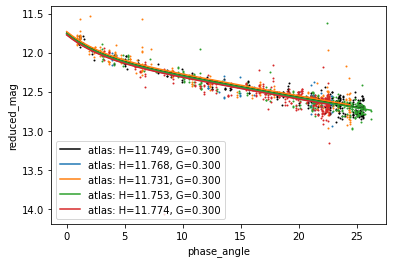

In [58]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])
    
# plot the first fit
df_plot = df_max
ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1,c="k")
phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
reduced_mag_atlas = model1(phase_angle)
ax1.plot(phase_angle,reduced_mag_atlas,
         label = "atlas: H={:.3f}, G={:.3f}".format(model1.H.value,model1.G.value),c="k")
    
for i,x in enumerate(epochs[1:]):
    
    if i==epoch_max:
        continue
        
    mask = ((df_data["mjd"]>=epochs[i]) & (df_data["mjd"]<epochs[i+1])) & (df_data["filter"]=="o")
    df = df_data[mask]
    print(len(df))
    
    # or add a min number of data points to fit here
    if len(df)<len(params):
        continue
    
    alpha = np.array(df["phase_angle"]) * u.deg
    mag = np.array(df["reduced_mag"]) * u.mag
    mag_err = np.array(df["merr"]) * u.mag

    model = fitter(HG_model_fixed, alpha, mag, weights=1.0/np.array(mag_err))



    df_plot = df

    ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"],s=1)
    phase_angle = np.linspace(0,np.amax(df_plot["phase_angle"])) * u.deg
    reduced_mag_atlas = model(phase_angle)
    ax1.plot(phase_angle,reduced_mag_atlas,
             label = "atlas: H={:.3f}, G={:.3f}".format(model.H.value,model.G.value))

ax1.legend()
ax1.invert_yaxis()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")

plt.show()


Get G from the epoch with the most data.
Quote the brightest H value for final absolute mag? Poorly sampled epochs could throw this off

How to fit c filter data? Keep G fixed?